Deep Learning
=============

Assignment 1
------------

SOLUTION : nghenglim.github.io

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [68]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [69]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [70]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [71]:
import random
for folder in train_folders:
    im_name = random.choice(os.listdir(folder))
    im_file = folder+"/"+im_name
    display(Image(filename=im_file))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.
data들을 감당할 수 있을만한 포멧으로 불러와보자. 개인적인 컴퓨터 세팅 상태에 따라, 컴퓨터 메모리 안에 전부를 넣을 수 없을 수도 있다. 때문에, 우린 각 class를 분리된 dataset에 load하고, 디스크에 저장하고, 독립적으로 계산(curate가 오타라고 생각..?!)할 것이다. 후에, 얘네들을 하나의 dataset으로, 다룰 수 있을 만큼의 크기로 합칠 것(merge)이다.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.
전체 dataset을 머신러닝하기 쉽게 바꿔준다.(데이터를 가공) 무엇으로? 부동소수점 값(검정 혹은 흰색)의 3차원 배열(이미지 인덱스, x, y(이미지 픽셀의 좌표)), 정규화(noralization, mean이 0에 가깝도록, 편차 약 0.5정도).

A few images might not be readable, we'll just skip them.
몇몇 이미지들은 읽을 수 없을 것이다. 그건 그냥 넘길 거야.

In [72]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32) #dataset을 정의해줌 (shape, float)로 저장되는데, shape에는 이미지 파일 수와 가로세로 크기 정보 담고 있다.
  print(folder)
  num_images = 0 #이미지 개수? ㄴㄴ 각 이미지의 인덱스를 매기는 역할을 할 변수
  for image in image_files:
    image_file = os.path.join(folder, image) #이미지 파일을 불러오고
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth # image_data 이미지파일을 float값(픽셀의 값)을 불러와서(scipy이용), 그 값의 범위가 [-1,+1]이 되도록 정규화 시킨다.
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data # 3차원 배열인 dataset에 image_data를 넣음. num_images는 인덱스를 정하는 역할
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :] # 잘 모르겠다. 마지막에 null을 처리해주는 건가?
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset)) # dataset(이미지 전체)의 평균 값 출력
  print('Standard deviation:', np.std(dataset)) # dataset(이미지 전체)의 편차 값 출력
  return dataset

# 각 폴더의 정보(=각 dataset의 정보)를 나타내는 .pickle을 생성..
# 이 pickle파일이 곧 각 dataset의 이름.
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.


정규화 잘 되었는 지 눈으로 확인.

---

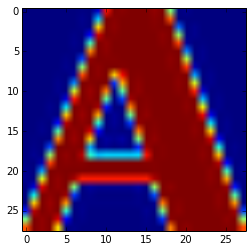

In [73]:
"""
# 상위 블로그의 답
for dtset in train_datasets:
    # first load the pickle file, loading one for illustration purpose
    t = pickle.load(open(dtset, "r"))
    #t = pickle.load(open(dtset))
    
    # need to use matplotlib inline if want to show at jupyter notebook
    #%matplotlib inline
    
    # plot one of image. the index 4 to be exactly
    plt.imshow(t[9], interpolation='nearest')
    #plt.imshow(t[9])
    
    # show the image
    plt.show()
"""
# udacity에서 제시된 답
pickle_file = train_datasets[0] # index 0 should be all As, 1 = all Bs, etc.
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f) # unpickle
    sample_idx = np.random.randint(len(letter_set)) # pick a random image index
    sample_image = letter_set[sample_idx, :, :] # extract a 2D slice
    plt.figure()
    plt.imshow(sample_image) # display it

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

각 클래스 별로 밸런스가 맞는지 확인(클래스별로 이미지 개수가 균형 맞게 있음)
---

In [74]:
len_dict = {}
folder_names = ["A","B","C","D","E","F","G","H","I","J"]
i = 0
for dtset in train_datasets:
    t = pickle.load(open(dtset,"r"))
    len_dict[folder_names[i]] = len(t)
    i = i + 1
print(len_dict)

{'A': 52909, 'C': 52912, 'B': 52911, 'E': 52912, 'D': 52911, 'G': 52912, 'F': 52912, 'I': 52912, 'H': 52912, 'J': 52911}


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.
필요에 따라 트레이닝 데이터들을 함치고 나눈다. 컴퓨터 상태에 따라, 모두를 할 수는 없다. 넌 트레인 사이즈를 조절할 수 있다. 라벨들은 정수 0부터 9까지의 나뉘어진 배열에 저장될 것이다.

Also create a validation dataset for hyperparameter tuning.
또한, 하이퍼파라미터 튜닝을 위해 타당한 데이터셋을 만들어라.

강의를 듣고 난 뒤에 정리 :
validate, train, test로 데이터를 나눌 것이다.
그리고 모든 pickle들(A.pickle, B.pickle...)을 하나의 pickle(notMNIST.pickle)로 합친다. 이렇게 하는 게 메모리가 적은 컴퓨터에게 도움이 된다(고 강의에서 얘기함).
메모리가 감당이 안되면 training set의 size를 조절할 수 있다.(train_size 변수가 그 역할)

In [75]:
def make_arrays(nb_rows, img_size): #배열 만들어줌. 만들어질 배열의 크기(인덱스 역할), 이미지 사이즈를 인자로
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32) # dataset 이미지사이즈
    labels = np.ndarray(nb_rows, dtype=np.int32) # label 라벨
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files) # pickle_files는 배열(각 피클(A.pickle...)의 파일 위치가 담긴). 이 배열의 길이는 곧 클래스의 개수
  valid_dataset, valid_labels = make_arrays(valid_size, image_size) # 배열 초기화
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes # 클래스 당 크기 (//는 나눗셈의 정수형 몫)
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0 # 각 클래스의 시작 인덱스
  end_v, end_t = vsize_per_class, tsize_per_class # 각 클래스의 끝 인덱스
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f) # 피클 파일 열어서 letter_set에 넣음.
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set) # letter_set 섞음
        if valid_dataset is not None: # valid dataset이 none이 아닐때,(앞서 배열 초기화를 해서 none은 아닐 것)
          valid_letter = letter_set[:vsize_per_class, :, :] # letter_set에서 valid 클래스 size 만큼 추출
          valid_dataset[start_v:end_v, :, :] = valid_letter # valid dataset에다가 해당 클래스 인덱스 범위 안에 넣음
          valid_labels[start_v:end_v] = label # valid label에다가 해당 클래스 인덱스 범위 안에 넣음
          start_v += vsize_per_class # 다음 인덱스를 위해서
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :] # letter_set에서 valid 이후부터 train size까지의 letter들을 가져옴
        train_dataset[start_t:end_t, :, :] = train_letter # 각 클래스에 해당하는 인덱스에 넣고
        train_labels[start_t:end_t] = label # 라벨도 가져오고
        start_t += tsize_per_class # 다음 인덱스를 위해서
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

다음, 이 데이터들을 섞을 것이다. 트레이닝과 테스트 분배를 하려면 라벨을 잘 섞는 게 중요하다.

In [76]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [77]:
print('train label : ', np.unique(train_labels))
print(np.bincount(train_labels))
#print(train_dataset)

train label :  [0 1 2 3 4 5 6 7 8 9]
[20000 20000 20000 20000 20000 20000 20000 20000 20000 20000]


Finally, let's save the data for later reuse:

In [78]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [79]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

이 데이터 셋에는 중복된 샘플들이 있다. 만약 중복이 없는 환경이라고 가정하에 이 모델을 사용하면, 결과가 왜곡된다.(반복되는 걸 기대했다면, 문제 없음). training, validation, test samples간에 얼마나 중복되어 있는지 측정하라.

training set과 test set의 중복된 data들 때문에, overfitting이 일어날 수 있기 때문에 중요한 작업이다.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [80]:
#"""
# 위 블로그의 해답
def reshape(a):
    return a.reshape(a.shape[0], a.shape[1]*a.shape[2]) # index는 그대로, size끼리 곱하는 건가

def unique_rows(data):
    uniq = np.unique(data.view(data.dtype.descr*data.shape[1]))
    return uniq.view(data.dtype).reshape(uniq.shape[0], data.shape[1])

t = pickle.load(open("notMNIST.pickle", "r")) # pickle 읽음
unique_td = unique_rows(reshape(t['train_dataset']))
duplicate_rows = len(t['train_dataset']) - len(unique_td)
print(duplicate_rows)
#"""
# udacity forum에 올라온 해답 (hash를 이용. 아 이렇게 할 수 있구나! 예전에 C++했을때 썼던 방법)
# 1
"""
train_dataset.flags.writeable=False
test_dataset.flags.writeable=False
dup_table = {} # 요기다가 hash로다가 index저장.
for idx, img in enumerate(train_dataset):
    h = hash(img.data)
    if h in dup_table and (train_dataset[dup_table[h]].data == img.data): # 앞서 저장했었고, 그 인덱스의 data와 현재data 비교
        print('Duplicate image : %d matches %d' % (idx, dup_table[h]))
    dup_table[h] = idx
for idx, img in enumerate(test_dataset):
    h = hash(img.data)
    if h in dup_table and (train_dataset[dup_table[h]].data == img.data):
        print('Test image %d is in the training set' % idx)
"""
# 2 (python 으로 time complex를 재는 방법을.. set function 이용(hash와 비슷))
"""
import time

def check_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    start = time.clock()
    hash1 = set([hash(image1.data) for image1 in images1]) # python의 built-in function set() 중복된 것을 없애거나 테스트할 때 쓰임. set([3, 2, 3 1])하면 [3, 2, 1] 
    hash2 = set([hash(image2.data) for image2 in images2]) # python docs에 2.7version을 보면 됨.(내 컴터엔 2.7이니까)
    all_overlaps = set.intersection(hash1, hash2) # intersection() set들을 넣어서 새로운 set을 만듬.
    return all_overlaps, time.clock()-start

r, execTime = check_overlaps(train_dataset, test_dataset)
print("# overlaps between training and test sets : ", len(r), "execution time : ", execTime)
r, execTime = check_overlaps(train_dataset, valid_dataset)
print("# overlaps between training and validation sets : ", len(r), "execution time : ", execTime)
r, execTime = check_overlaps(valid_dataset, test_dataset)
print("# overlaps between validation and test sets : ", len(r), "execution time : ", execTime)
"""
# 3
# hadoop을 설치해서 spark를 이용해 빠르게 결과를 낼 수도 있다(parrallelize).전체를 비교하려면 bucket을 쓰는게 best이다.
# 내 눈엔 bucket이 hash와 비슷해 보임. 애초에 개념자체가 비슷하지 않나..?!
# 코드는 forum에서 볼 것.

# 4
# hashlib and numpy (fastest I think)
"""
import time
import hashlib

t1 = time.time()

train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
test_hashes = [hashlib.sha1(x).digest() for x in test_dataset]

valid_in_train = np.in1d(valid_hashes, train_hashes)
test_in_train = np.in1d(test_hashes, train_hashes)
test_in_valid = np.in1d(test_hashes, valid_hashes)

valid_keep = ~valid_in_train
test_keep = ~(test_in_train | test_in_valid)

valid_dataset_clean = valid_dataset[valid_keep]
valid_labels_clean = valid_labels[valid_keep]

test_dataset_clean = test_dataset[test_keep]
test_labels_clean = test_labels[test_keep]

t2 = time.time()

print("Time: %0.2fs" % (t2-t1))
print("valid -> train overlap: %d samples" % valid_in_train.sum())
print("test -> train overlap: %d samples" % test_in_train.sum())
print("test -> valid overlap: %d samples" % test_in_valid.sum())
"""

12699


'\nimport time\nimport hashlib\n\nt1 = time.time()\n\ntrain_hashes = [hashlib.sha1(x).digest() for x in train_dataset]\nvalid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]\ntest_hashes = [hashlib.sha1(x).digest() for x in test_dataset]\n\nvalid_in_train = np.in1d(valid_hashes, train_hashes)\ntest_in_train = np.in1d(test_hashes, train_hashes)\ntest_in_valid = np.in1d(test_hashes, valid_hashes)\n\nvalid_keep = ~valid_in_train\ntest_keep = ~(test_in_train | test_in_valid)\n\nvalid_dataset_clean = valid_dataset[valid_keep]\nvalid_labels_clean = valid_labels[valid_keep]\n\ntest_dataset_clean = test_dataset[test_keep]\ntest_labels_clean = test_labels[test_keep]\n\nt2 = time.time()\n\nprint("Time: %0.2fs" % (t2-t1))\nprint("valid -> train overlap: %d samples" % valid_in_train.sum())\nprint("test -> train overlap: %d samples" % test_in_train.sum())\nprint("test -> valid overlap: %d samples" % test_in_valid.sum())\n'

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

sklearn의 logistic regression을 이용해 accuracy 도출. training set이 50, 100, 1000, 5000 각각 나눠서.

---

0.8774


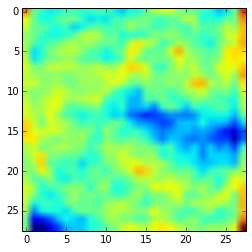

In [95]:
# blog 답
"""
def reshape(a):
    return a.reshape(a.shape[0], a.shape[1]*a.shape[2]) # index는 그대로, size끼리 곱하는 건가

t = pickle.load(open("notMNIST.pickle", "r"))
y = t['train_labels']
X = reshape(t['train_dataset']) # reshape it to 2d array
del(t) # this should free up more memory spaces
# choose from 0:10000 because not enough memory for the docker
# probably a way to do batch learning with scikit-lear
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# http://scikit-learn.org/stable/auto_examples/classification/plot_classification_probability.html
C = 1.0
classifier = LogisticRegression(C=C, penalty='l1')
classifier.fit(X[0:10000], y[0:10000])
y_pred = classifier.predict(X)
classif_rate = np.mean(y_pred.ravel() == y.ravel())*100
print("classif_rate for %f" % (classif_rate))
# we now see how it is predicted using sample 10001 to 20000, which is not used for training.
# actually should calculate the accuracy in percentage.
print(y[10001:20000])
print(y_pred[10001:20000])
"""
# 1
num_samples = 10000
n_classes = 10

(samples, width, height) = train_dataset.shape
X = np.reshape(train_dataset, (samples, width*height))[0:num_samples]
y = train_labels[0:num_samples]

# This gives a nice image of a Letter
example = X.reshape(num_samples, width, height)[0]
plt.imshow(example)
#"""
lr = LogisticRegression(C=0.01)
lr.fit(X, y)

(samples, width, height) = test_dataset.shape
X_test = np.reshape(test_dataset, (samples, width*height))
y_test = test_labels

print(lr.score(X_test, y_test))

# This gives a totally random looking image, but I expect it should look like a fuzzy kind of letter.
#filter_a = lr.coef_.reshape(n_classes, width, height)[0] # A
#plt.imshow(filter_a)

#filter_a = lr.coef_.reshape(n_classes, width, height)[1] # B
#plt.imshow(filter_a)

filter_a = lr.coef_.reshape(n_classes, width, height)[2] # C
plt.imshow(filter_a)
#"""
